# Predicting Losses #
<hr class="header-line"/>

In this section, we will build a sample loss model to predict losses.

#### Why Should Fico Care About Predicting Losses? ####

**1. Equity**

+ How much equity does Fico need to absorb potential lossess?
+ Fico *expects* to have average losses of `x` per year, **but** in any one year, Fico might experience losses `10x` or `100x`.
+ Fico needs an equity base to support those extreme years.

**2. Pricing**

+ Loan losses are Fico's largest expense.
+ Interest rate to charge borrower is a function of how much we expect to lose.

**3. Return**

+ Is this loan worthwhile?
+ Is this *entire loan portfolio* worthwhile?

#### The 3 Components of Loss ####

**Exposure at Default, EAD**

+ whatever is owed (principal only)

**Probability of Default, PD**

+ the likelihood a borrower will not repay the loan

**Loss Given Default, LGD**

+ the actual amount of loss on the loan, if the borrower defaults.

The expected average loss on a loan portfolio *in a given year* is a very simple formula:

$$EAD * PD * LGD$$

# Loss Distribution #
<hr class="header-line"/>

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Markdown

from htsfi.main import *

update_style()
plt.style.use('htsfi')

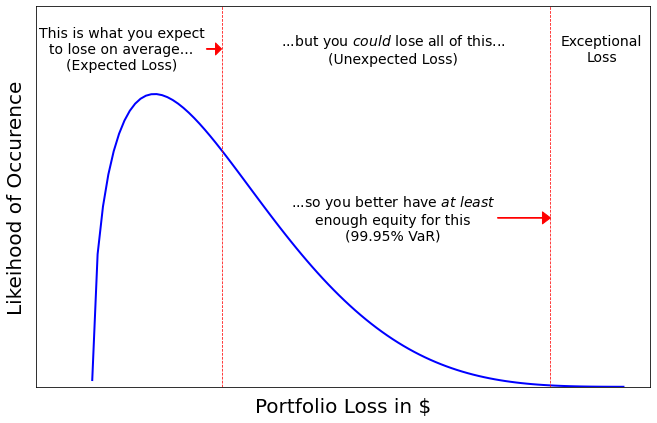

In [2]:
import numpy as np
from scipy.stats import bernoulli as bern, beta, gamma, norm

a = 1.5
b = 5
cvar = 0.9995

fig, ax = plt.subplots(figsize=(11,7))

x = np.linspace(beta.ppf(0.000001, a, b), beta.ppf(0.999999, a, b), 100)
rv = beta(a, b)
ax.plot(x, rv.pdf(x), 'b', lw=2)
ax.axvline(rv.mean(), c='r', ls='--', lw=.75)
ax.axvline(rv.ppf(cvar), c='r', ls='--', lw=.75)

h = 3.25
plt.annotate(
    'This is what you expect\nto lose on average...\n(Expected Loss)', (rv.mean(), h), 
    xytext=((rv.mean() - .1)/2.5, h), 
    ha='center', va='center',
    arrowprops={'width': .25, 'headlength': 6, 'color': 'r'}
)
plt.annotate(
    '...but you ' + r'${could}$' + ' lose all of this...\n(Unexpected Loss)', 
    ((rv.mean()), h,),
    ((rv.ppf(.9995) - rv.mean() - .05), h,),
    ha='center', va='center',
)
plt.annotate(
    '...so you better have ' + r'${at}$ ${least}$' + '\nenough equity for this\n(99.95% VaR)', (rv.ppf(cvar), h/2), 
    xytext=(rv.ppf(.9995) - rv.mean() - .05, h/2), 
    ha='center', va='center',
    arrowprops={'width': .25, 'headlength': 8, 'color': 'r'}
)

plt.text((1 + rv.ppf(cvar)) / 2, h, 'Exceptional\nLoss', ha='center', va='center')

ax.set_xlim(-.1, ax.get_xlim()[1])
ax.set_ylim(0, rv.pdf(x).max()*1.3)

ax.tick_params('both', width=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylabel('Likeihood of Occurence')
ax.set_xlabel('Portfolio Loss in $')

plt.show()

To predict losses, we need to map our portfolio onto a **Loss Distribution**.

The parameters of the distribution are unique to each loan book at any moment in time based on:

+ number of loans
+ size of loans
+ ratings of different borrowers
+ value of assets under each loan
+ correlation of defaults and correlation of defaults / asset values

Here are some key terms we will use:

**Beta Distribution**

+ the distribution of losses in any given year is generally believed to follow a Beta distribution, where very small losses occur the vast majority of years and very large losses occur sporadically.

**Expected Loss (EL)**

+ the mean value of the Loss distribution
+ if the loan book is correctly modelled, i.e. borrower PDs are accurate, equipment market values are accurate etc., this is the average amount of losses Fico should experience in the long-term.
    
**Unexpected Loss (UL)**

+ one standard deviation from the mean of the Loss distribution
+ varies by loan book but typically loan losses should be less than UL in 80% of years

**Economic Capital (EC)**

+ amount of equity required to absorb extreme events
+ sometimes set using Value-at-Risk (VaR)
    + [agencies typically consider VaR as a factor for determining a bank's credit rating](https://helda.helsinki.fi/bof/bitstream/handle/123456789/7797/128554.pdf?sequence=1)
    + a 99.95% VaR can be interpreted as "*this level of losses is expected in 5 out of every 10,000 years*"

In [3]:
html = '<table class="fi-table">'
html +=  '<thead>'
html +=    '<tr>'
html +=      '<th class="fi-table">S&P</th>'
html +=      '<th class="fi-table">VaR</th>'
html +=    '</tr>'
html +=  '</thead>'
html +=  '<tbody>'
html +=    '<tr>'
html +=      '<td class="fi-table">AA</td>'
html +=      '<td class="fi-table">99.97%</td>'
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="fi-table">A</td>'
html +=      '<td class="fi-table">99.95%</td>'
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="fi-table">BBB+</td>'
html +=      '<td class="fi-table">99.9%</td>'
html +=    '</tr>'
html += '</tbody>'
html += '</table>'

display(HTML(html))

S&P,VaR
AA,99.97%
A,99.95%
BBB+,99.9%


**Other Considerations**

+ Correlation of Defaults:
    + exogeneous factors may result in borrowers defaulting at the same time and more than they would independently. This increases losses at those times.
+ Correlation of PD and LGD:
    + simplest (and prevailing) assumption is PD and LGD are uncorrelated
    + more realistic assumption is PD and LGD are correlated
+ 3rd party providers
    + data and modelling tools can be purchased from 3rd parties
    + Examples: 
        + https://theanalyticsboutique.com/demos/

#### Process to Determine Loss Distribution ####

+ Determine **PD**, **LGD**, LGD distribution, PD correlations, PD/LGD correlations (if any).
+ Find **EL** and **UL**.
+ Run Monte Carlo simulations. Determine the **Loss Distribution** of the portfolio.
+ Find best fit for beta distribution
+ Find **Economic Capital** through **VaR** (for whatever credit rating desired).

+ Fico needs equity equal to *at least* the **Economic Capital**.
+ Extreme Value Theory can be used to protect against even greater tail risks.

# Probability of Default #
<hr class="header-line"/>

+ determined through analysis of company financial statements, business/industry risks, and exogenous factors like economic activity.
+ bond/credit ratings are categorized based on PD. The S&P ratings and their analogous PDs are shown below:

In [4]:
from htsfi.main import *

html = '<table class="fi-table">'
html +=  '<thead>'
html +=    '<tr>'
html +=      '<th class="fi-table">S&P</th>'
html +=      ''.join([f'<th class="fi-table">{rat}</th>' for rat in SPs])
html +=    '</tr>'
html +=  '</thead>'
html +=  '<tbody>'
html +=    '<tr>'
html +=      '<td class="fi-table">PD</td>'
html +=      ''.join([f'<td class="fi-table">{pd:.2%}</td>' for pd in PDs])
html +=    '</tr>'
html += '</tbody>'
html += '</table>'

display(HTML(html))

S&P,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,CCC+,CCC-,CC
PD,0.01%,0.03%,0.04%,0.04%,0.05%,0.08%,0.10%,0.13%,0.17%,0.24%,0.34%,0.53%,0.73%,1.40%,2.45%,6.00%,9.57%,16.72%,33.32%


+ credit ratings BBB+ and greater are typically considered investment grade.
+ rating BBB to CCC+/CCC are consider "junk" or speculative.
+ CCC+/CCC or worse is typically considered a default

+ The distribution of ratings within a portfolio are often unique to the portfolio: what borrowers are targeted? what is risk management quality? etc.

+ For now, it is useful  to assume a portfolio with normally distributed PDs with the following parameters:

    + $\mu = .44$%
    + $\sigma = .2$%

This portfolio would have a distribution as per below. Note the x-axis increases exponentially, so the normal distribution is skewed.

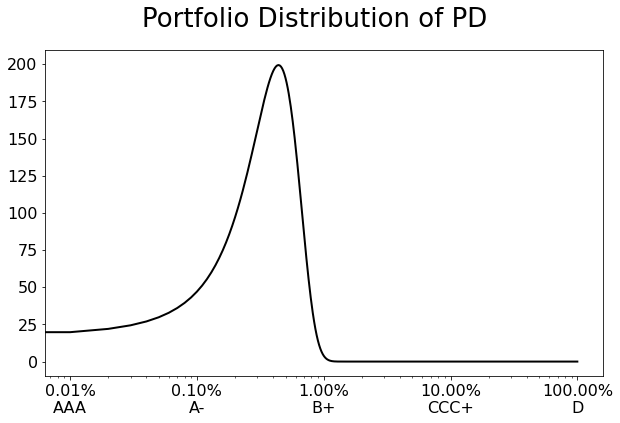

In [5]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    mu = .0044
    std = .002

    x = np.linspace(0,1,10000)
    y = norm.pdf(x, mu, std)
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, y, 'k-', lw=2)

    ax.set_xscale('log')

    ratlabs = ['', '', 'AAA', 'A-', 'B+', 'CCC+', 'D', '']
    ax.set_xticklabels([f'{val:.2%}\n{ratlab}' for val, ratlab in zip(ax.get_xticks(), ratlabs)])

    plt.suptitle('Portfolio Distribution of PD')
    
    plt.show()

The portfolio, on average, would have "junk" exposure, but we can see above that the majority of borrowers would be rated stronger.

# Loss Given Default #
<hr class="header-line"/>

A detailed discussion of [LGD is here](lgd.ipynb). For this exercise, we are just looking for a credible way to model it.

+ often modelled based on the Beta distribution, as per [Moody's LossCalc](http://www.defaultrisk.com/_pdf6j4/losscalc_methodology.pdf)
+ the Beta distribution isn't great for leases, because it does not allow for recovery gains. [More complex models should be considered for leasing](https://www.cairn.info/revue-finance-2005-2-page-35.html).
+ There is limited data available on equipment recoveries, but [one study shows recoveries in various European countries between 1976 and 2002](https://www.cairn.info/revue-finance-2005-2-page-35.html). The average LGD and standard deviation varied quite widely, so judging by the wind we'll go with:

$$
\mu_{LGD} = .4
\\\sigma_{LGD} = .4
$$
    
+ the Beta distribution is generally parameterized as follows:

$$\beta(\alpha, \beta)$$

+ but it can also be built from the mean and standard deviation:

$$
\mu = \frac{\alpha}{\alpha+\beta}
\\\sigma^2 = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha+\beta+1)}
$$

We have some helper functions written derive $\alpha$/$\beta$ from $\mu$/$\sigma$.

In [35]:
mu = .4
std = .4

a, b = beta_params_from_descript(mu, std**2)

In [39]:
md = 'This results in alpha = '
md += f' {a:.1f}'
md += r' and beta = '
md += f' {b:.1f}.'
md += r' Plug those into Beta'
md += f'({a:.1f}, {b:.1f}) and you get the following LGD distribution:'

display(Markdown(md))

This results in alpha =  0.2 and beta =  0.3. Plug those into Beta(0.2, 0.3) and you get the following LGD distribution:

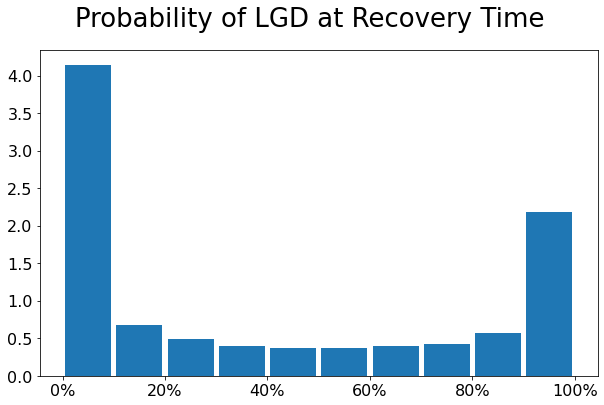

In [8]:
r = beta.rvs(a, b, size=100000)

fig, ax = plt.subplots(figsize=(10,6))
ax.hist(r, density=True, rwidth=.9)

import matplotlib.ticker as ticker
@ticker.FuncFormatter
def major_formatter(x, pos):
    return f'{x:.0%}'

ax.xaxis.set_major_formatter(major_formatter)

plt.suptitle('Probability of LGD at Recovery Time')
plt.show()

We can see that the majority of defaults result in almost no loss or an entire loss.

# Loss Models #
<hr class="header-line"/>

A loss model must:

+ determine expected losses at loan level
+ determine expected losses at portfolio level, and how to aggregrate based on correlated outcomes.

Loss models have developed increasing complexity in the past two decades but regulatory requirements of banks and other FIs still center around Basel 2, which has a basic assumption that PD and LGD are uncorrelated. This assumption has been questioned more recently (and intuitively seems weak).

We will show examples for both (though the latter is much more complicated and so the example is partial).

#### Model 1: PD / LGD Uncorrelated  ####

+ Assumes that the loss given default on the loan is *not* related to the default. Picture an asset whose value does *not* change regardless of economic circumstances.

+ The model *does* account for correlation of default among obligors. i.e. there is some exogneous factor(s) that cause bororwers to default at the same time. This makes sense intuitively.

**Single Loan**

$$EL = EAD * PD * LGD$$

often shown for each dollar of EAD as:

\begin{equation}
UL = EAD * \sqrt(PD*\sigma^2_{LGD} + LGD^2*\sigma^2_{PD})
\\\sigma^2_{PD} = (PD)(1-PD)
\\\sigma^2_{LGD} = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}
\end{equation}

**Multiple Loans**

\begin{equation}
EL_p = \sum^n_{i=1}{EAD_i*PD_i*LGD_i}
\\UL_p = \sqrt{\sum_i\sum_j\rho_{ij}w_iw_jUL_iUL_j}
\end{equation}

where:

\begin{equation}
p_{i,j} = 1 \text{ if }i=j
\\w_i = EAD_i / EAD_p
\\EAD_p = \sum^n_{i=0}EAD_i
\\UL_i = EAD_i * \sqrt(PD^2_i*\sigma^2_{LGD, i} + LGD^2_i*\sigma^2_{PD,i})
\end{equation}

In [9]:
# Confirm Equivalence of Formulations
p12 = .5

corrmat = np.ones(shape=(2,2))
corrmat[0, 1] = p12
corrmat[1, 0] = p12

EAD = 1
EAD1 = EAD / 2
EAD2 = EAD / 2
w1 = EAD1 / EAD
w2 = EAD2 / EAD
w = np.array([w1, w2])
UL1 = .25
UL2 = .25
ULs = np.array([UL1, UL2])

rloop = np.zeros(shape=(2,2))

for i in range(len(w)):
    for j in range(len(w)):
        rloop[i][j] += corrmat[i, j]*w[i]*w[j]*ULs[i]*ULs[j]

rform = (UL1**2 + UL2**2 + 2*p12*UL1*UL2)*EAD1*EAD2/(EAD**2)

rnumpy = np.multiply(corrmat, np.multiply(np.outer(w,w), np.outer(ULs, ULs,)))

assert rloop.sum() == rform == rnumpy.sum()

try:
    p = np.random.randint(1,10,size=(3,3))
    corrs_to_corrmat(p)
except AssertionError as e:
    assert str(e) == '`p` must be an nx1 array'

**Example**

Assumptions:

+ 5 loans
+ \$500K total outstanding
+ PD is Bernoulli variable, however, generated randomly via Normal distribution as per [above](#Probability-of-Default).
+ LGD is Beta variable as per [above](#Loss-Given-Default)
+ all loans are for the same asset, therefore, have same LGD distribution
+ PD and LGD are uncorrelated

First, we create the loan exposures.

In [10]:
# Loan Portfolio
n = 5
loans_t = 5*10**5
randloans = np.random.uniform(0.1,1,n)
EAD = (randloans / randloans.sum())*loans_t
w = EAD / EAD.sum()
print (f'Confirming Portfolio Size: {EAD.sum():,.2f}')

Confirming Portfolio Size: 500,000.00


Now, we created the PDs for each loan.


In [11]:
# PD for each borrower/loan.
pd_mu = 0.0044
pd_std = 0.002
p_of_d = np.random.normal(pd_mu, pd_std, n)
count, bins = np.histogram(p_of_d, bins=PDs)
binned = np.digitize(p_of_d, bins)
rats = np.array(SPs)[binned]

p_of_d = np.where(p_of_d<0, 0, p_of_d)

pd_var = bern.var(p_of_d)     # PD for each individual loan is bernoulli distributed and has its own variance.

And the LGDs for each loan.

In [12]:
# LGD
lgd_mu = .4
lgd_std = .4

a, b = beta_params_from_descript(lgd_mu, lgd_std**2)
lgd_freeze = beta(a, b)
lgd = lgd_freeze.rvs(size=n)

lgd_var = np.repeat(lgd.var(), n)

Then EL and UL can be calculated as:

In [13]:
el = EAD*p_of_d*lgd
ul = loan_ul(EAD, p_of_d, lgd, pd_var, lgd_var)

We show the results for each individual loan below:

In [14]:
from IPython.core.display import HTML, display

html = '<table>'
html +=  '<thead>'
html +=    '<tr>'
html +=      '<th class="loan-table"></th>'
html +=      ' '.join([f'<th class="loan-table">Loan {i + 1}</th>' for i in range(n)])
html +=    '</tr>'
html +=  '</thead>'
html +=  '<tbody>'
html +=    '<tr>'
html +=      '<td class="loan-table">Amount</td>'
html +=      ' '.join([f'<td class="loan-table">{val:,.2f}</td>' for val in EAD])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">Probability<br>of<br>Default (PD)</td>'
html +=      ' '.join([f'<td class="loan-table">{val:.2%}</td>' for val in p_of_d])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">S&P<br>Rating</td>'
html +=      ' '.join([f'<td class="loan-table">{val}</td>' for val in rats])
html +=    '</tr>'
html +=    '<tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">Loss Given<br>Default (LGD)</td>'
html +=      ' '.join([f'<td class="loan-table">{val:.2%}</td>' for val in lgd])
html +=    '</tr>'
html +=      r'<td class="loan-table">$\sigma^2_{PD}$</td>'
html +=      ' '.join([f'<td class="loan-table">{val:.2%}</td>' for val in pd_var])
html +=    '</tr>'
html +=    '<tr>'
html +=      r'<td class="loan-table">$\sigma^2_{LGD}$</td>'
html +=      ' '.join([f'<td class="loan-table">{val:.2%}</td>' for val in lgd_var])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">Expected<br>Loss (EL)</td>'
html +=      ' '.join([f'<td class="loan-table">{val:,.2f}</td>' for val in el])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">Unexpected<br>Loss (UL)</td>'
html +=      ' '.join([f'<td class="loan-table">{val:,.2f}</td>' for val in ul])
html +=    '</tr>'
html +=  '</tbody>'
html += '</table>'

display(HTML(html))

Now, we must combine the above results to find the likely performance of the entire portfolio. Remember when trying to determine the **Loss Distribubion**, as per formulations above, 

+ expected losses are *additive* 
+ unexpected losses are *not additive*
+ probability of default may be correlated, thereby impacting unexpected loss

We will consider three scenarios:

**PD entirely uncorrelated**

$\rho_{ij} \text{ for all } i,j = 0$

**PD all perfectly correlated**

$\rho_{ij} \text{ for all } i,j = 1$

**PD correlated**

$.2 < \rho_{ij} < .8 \text{ where }i \neq j$

Scenarios 1 and 2 can be developed rather easily.

In [15]:
p = np.zeros(n)

port_ul1 = port_ul_w_corr(w, ul, p)

p = np.ones(n)
port_ul2 = port_ul_w_corr(w, ul, p)

For Scenario 3, we must prepare a correlation matrix. First we randomly generate the correlation factors.

In [16]:
p = np.random.uniform(.2, .8, n)

Then build a 2-D correlation matrix using our hepler function `corrs_to_corrmat`.

In [17]:
print (np.around(corrs_to_corrmat(p), 2))

[[1.   0.78 0.76 0.61 0.72]
 [0.78 1.   0.61 0.72 0.39]
 [0.76 0.61 1.   0.39 0.39]
 [0.61 0.72 0.39 1.   0.39]
 [0.72 0.39 0.39 0.39 1.  ]]


Then, multiply the correlation matrix by the weights and individual expected losses. This is all done inside the helper function `port_ul_w_corr`.

In [18]:
port_ul3 = port_ul_w_corr(w, ul, p)
port_uls = [port_ul1, port_ul2, port_ul3]

This results in the below:

In [40]:
from IPython.core.display import HTML, display

html = '<table>'
html +=  '<thead>'
html +=    '<tr>'
html +=      '<th class="loan-table"></th>'
html +=      ' '.join([f'<th class="loan-table">Scenario {i + 1}</th>' for i in range(3)])
html +=    '</tr>'
html +=  '</thead>'
html +=  '<tbody>'
html +=    '<tr>'
html +=      '<td class="loan-table">Amount</td>'
html +=      ' '.join([f'<td class="loan-table">{EAD.sum():,.2f}</td>' for i in range(3)])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">EL, portfolio</td>'
html +=      ' '.join([f'<td class="loan-table">{el.sum():,.2f}</td>' for i in range(3)])
html +=    '</tr>'
html +=    '<tr>'
html +=      '<td class="loan-table">UL, portfolio</td>'
html +=      ' '.join([f'<td class="loan-table">{val:,.2f}</td>' for val in port_uls])
html +=    '</tr>'
html +=  '</tbody>'
html += '</table>'

display(HTML(html))

,Scenario 1,Scenario 2,Scenario 3
Amount,"2,000,000.00","2,000,000.00","2,000,000.00"
"EL, portfolio","1,028.23","1,028.23","1,028.23"
"UL, portfolio","11,811.79","26,411.96","21,258.19"


In [41]:
co = el.sum() / EAD.sum()
md = 'So, in our hypothetical \\$2MM loan portfolio, we should expect loan losses'
md += f' of {co:.2%} per year on average.'

display(HTML(md))

This is below the market average in the US, seen below and found [here](https://www.elfaonline.org/data/mlfi-25-monthly-leasing-and-finance-index/view-mlfi/monthly-leasing-and-finance-index-december-2020), but still pretty good for some rough math.

<img src="_static/dec2020_lease_charge_offs.png" width="800" alt="Image Not Loaded"></img>

But we should also note that the Unexpected Loss could be 10x-20x more than the Expected Loss in a given year. So should we hold enough capital to absorb the Unexpected Loss? Nope, we should hold even more than that.

#### Model 2: PD / LGD Correlated  ####
+ To be fleshed in greater detail.
+ [PD and LGD are likely correlated](https://www.moodysanalytics.com/-/media/whitepaper/before-2011/10-05-02-implications-of-PD-lgd-correlation-in-a-portfolio-setting.PDf)
+ current accepted approaches to risk modelling to not account for this (e.g. Basel 2)
+ usually considered when the value of the asset is dependent on the economic cycle
+ models of PD/LGD correlation are generally very complicated. we will use simple assumptions to show the effect on expected loss.
+ to account for this, EL can incorporate a covariance term for PD / LGD

+ a borrower may default because of exogeneous circumstances that also impact the market value of the asset
+ a borrower that defaults may be more likely to depreciate an asset through improper use (i.e. poor maintenance, etc).


Assumes:

+ Linear relationship between PD and LGD
+ $R^2$ = .5   [per historical data detailed in Figure 1 here(file:///Users/spindicate/Downloads/SSRN-id1297797.pdf)
+ all defaults and all assets have the same correlation of PD and LGD

The main adjustment to the loss model is the addition of a covariance term to the Expected Loss.

$$EL = PD*LGD + cov(PD, LGD)$$

where:

$$COV(PD,LGD) = \rho_{PD,LGD}*\sigma_{PD}*\sigma_{LGD}$$

and

$$\rho_{PD,LGD} = R = \sqrt{.5}$$

where:

$$cov(PD, LGD) = \rho_{PD,LGD}*\sigma_{PD}*\sigma_{LGD}$$

$$UL = EAD * \sqrt(PD^2*\sigma^2_{LGD} + LGD^2*\sigma^2_{PD})$$


For multiple loans:

$$EL_p = \sum^n_{i=1}({EAD_i*PD_i*LGD_i + cov(PD_i, LGD_i)})$$

$$\sum^n_{i=1}cov(PD_i, LGD_i) = n*cov(PD, LGD)$$

$$EL_p = (\sum^n_{i=1}EAD_i*PD_i*LGD_i) + n*cov(PD, LGD)$$

The UL is very complicated and should be derived via simulation.

# Simulating Losses #
<hr class="header-line"/>

To map the **Loss Distribution**, we must simulate portfolio outcomes based on **Loss Model** we have constructed.

**Goal**

1. Create a sample portfolio from our Loss Model
2. Generate 50,000 simulations of the portfolio performance in a single year.
3. The amount of loss in each simulation will be recorded.
4. A Beta distribution will be fit to the loss record.

**Process**

1. Generate `n=20` loans totaling \$2MM aggregate
2. Generate PD for each borrower/loan from normal distribution as per [here](#Probability-of-Default).
3. Simulate default events
    + generate `n` random standard normals, denoted `e`
    + generate correlation matrix of defaults across all borrowers for all simulations([values informed by Chapter 7, Appendix B of Ong](https://www.amazon.ca/Internal-Credit-Risk-Models-Performance/dp/1899332030)).
    + find transformation matrix via Cholesky method
    + correlated defaults found as `e_prime`
    + defaults occur when `e_prime` is less than the inverse normal of PD    
4. For each default, generate an LGD based on the distribution used earlier
    + where the borrower has not defaulted, `LGD = 0%`.

In [21]:
from scipy.stats import invgauss
from scipy.linalg import eigh, cholesky, svd

# Loan amounts
n = 20
n_samples = 50000

loans_t = 2*10**6
randloans = np.random.uniform(0.1,1,n)
EAD = (randloans / randloans.sum())*loans_t
w = EAD / EAD.sum()

# PD for each borrower/loan.
pd_mu = 0.0044
pd_std = 0.002
p_of_d = np.random.normal(pd_mu, pd_std, n)
p_of_d = np.where(p_of_d<0, 0, p_of_d)
pd_var = bern.var(p_of_d)

# Correlation matrix
e = norm.rvs(0, 1, size=(n, n_samples)) # this creates defaults for ALL borrowers in ALL simulations
p = np.random.uniform(.01, .13, n)
corrmat = corrs_to_corrmat(p)

c = cholesky(corrmat, lower=True)

e_prime = np.dot(c, e).T
pd_inv = np.repeat(norm.ppf(p_of_d), n_samples).reshape(n_samples, n)

If $e\prime_{i,j} < N^{-1}(PD_{i})$ for any $i,j$ then borrower $i$ defaulted in simulation $j$

In [22]:
in_default = e_prime < pd_inv
print (in_default.shape)

(50000, 20)


`in_default` is now a boolean array where `True` means default and `False` means no default for every borrower (20) in every simulation (50,000).

As a check, we can sum all the defaults and divide by the total number of instances of borrowers (n borrowers X n_samples).

In [23]:
default_per = (e_prime < pd_inv).sum() / (n*n_samples)
print (default_per)

0.003676


In [24]:
text = f'The process resulted in {default_per:.2%} defaults'
text += ' which aligns closely with the expected value'
text += f' of {pd_mu: .2%} mean of the Normal distribution used.'

from IPython.core.display import display, Markdown

display(Markdown(text))

The process resulted in 0.37% defaults which aligns closely with the expected value of  0.44% mean of the Normal distribution used.

Now, randomly generated LGDs for *only those loans that defaulted*.

In [25]:
# LGD
mean = .4
lgd_std = .4
a, b = beta_params_from_descript(mean, lgd_std**2)
lgds = np.zeros(shape=in_default.shape) # LGDs for all loans start at 0%

i_loss = np.argwhere(in_default)
lgd_rands = beta.rvs(a, b, size=i_loss.shape[0]) 

# Insert LGDs where there was a default
for i in range(i_loss.shape[0]):
    x, y = i_loss[i]
    lgds[x, y] = lgd_rands[i]

Finally, we multiply the loan amounts by the LGDs to get the loss on every loan in every simulation.

In [26]:
losses = np.repeat(EAD, n_samples).reshape(n_samples, n) * lgds

simloss = losses.sum(axis=1)
simloss_gt0 = simloss[simloss>0]

print (simloss.shape[0], simloss_gt0.shape[0])

50000 3410


In [43]:
from IPython.core.display import Markdown

md = '`simloss_gt0` is now an array of simulations where loss was greater than 0.'
md += f' We can see from the above, out of {simloss.shape[0]:,.0f} simulations,'
md += f' only {simloss_gt0.shape[0]:,.0f} had *any* defaults.'
md += ' The small size of the portfolio skews the distribution and so simulations with'
md += ' losses of zero will be ignored for distribution fitting.'

display(Markdown(md))

`simloss_gt0` is now an array of simulations where loss was greater than 0. We can see from the above, out of 50,000 simulations, only 3,410 had *any* defaults. The small size of the portfolio skews the distribution and so simulations with losses of zero will be ignored for distribution fitting.

A few key statistics from the data

In [28]:
val = f'Average losses in each year: ${simloss.mean():,.2f}'
val += f'\nAverage Percentage Losses: {simloss.mean()/EAD.sum():.2%}'
val += f'\nNumber of years with 0% loss: {simloss.shape[0] - simloss_gt0.shape[0]:,.0f}'
val += f'\nAverage losses in years with loss: ${simloss_gt0.mean():,.2f}'
val += f'\nAverage Percentage Losses in years with loss: {simloss_gt0.mean()/EAD.sum():.2%}'
val += f'\nMaximum Loss in any Year: ${simloss_gt0.max():,.2f}'
print (val)

Average losses in each year: $2,756.37
Average Percentage Losses: 0.14%
Number of years with 0% loss: 46,590
Average losses in years with loss: $40,416.01
Average Percentage Losses in years with loss: 2.02%
Maximum Loss in any Year: $348,030.24


Now we can fit the distribution and plot it against the simulation.

In [29]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    lnspc = np.linspace(0, simloss_gt0.max(), len(bins))
    params = beta.fit(simloss_gt0)
    ld = beta(*params)

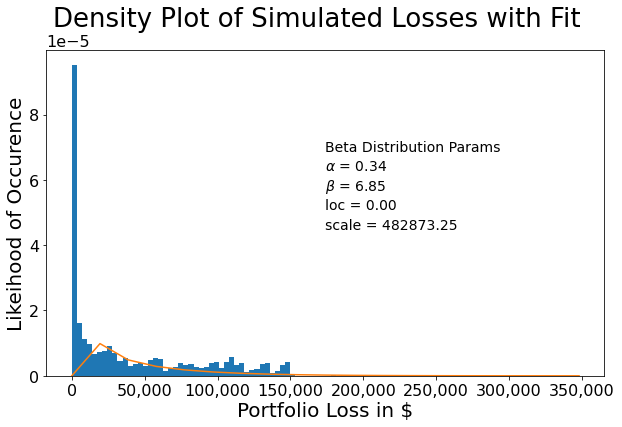

In [30]:
import warnings

fig, ax = plt.subplots(figsize=(10,6))

vals, bins, _ = ax.hist(simloss_gt0, bins=100, density=True)

ax.plot(lnspc, ld.pdf(lnspc), label="Beta")

ax.text(.5, .69, 'Beta Distribution Params', transform=ax.transAxes)
ax.text(.5, .63, r'$\alpha$' + f' = {params[0]:.2f}', transform=ax.transAxes)
ax.text(.5, .57, r'$\beta$' + f' = {params[1]:.2f}', transform=ax.transAxes)
ax.text(.5, .51, f'loc = {params[2]:.2f}', transform=ax.transAxes)
ax.text(.5, .45, f'scale = {params[3]:.2f}', transform=ax.transAxes)

import matplotlib.ticker as ticker
@ticker.FuncFormatter
def major_formatter(x, pos):
    return f'{x:,.0f}'

ax.xaxis.set_major_formatter(major_formatter)

ax.set_xlabel('Portfolio Loss in $')
ax.set_ylabel('Likeihood of Occurence')
plt.suptitle('Density Plot of Simulated Losses with Fit')

plt.show()

FINALLY, we can find the amount of equity Fico should hold at the 99.95% VAR level of our loss distribution, good enough for a AA credit rating.

In [31]:
print (ld.ppf(0.9995))

272079.72695651004


In [44]:
n_gt_var = simloss[simloss>ld.ppf(0.9995)].shape[0]

md = 'If Fico has a \\$2MM loan portfolio with the characteristics described here,'
md += f' it should have equity of at least {ld.ppf(0.9995):,.2f}.'

md += '\n\nLooking closer at the distribution, in the vast majority of cases'
md += ' this amount would protect against solvency, however, it must be noted that in'
md += f' {n_gt_var} out of the {simloss.shape[0]:,.0f} simulations, the loss would exceed' 
md += ' the equity base and Fico would be in default.'

display(Markdown(md))

If Fico has a \$2MM loan portfolio with the characteristics described here, it should have equity of at least 272,079.73.

Looking closer at the distribution, in the vast majority of cases this amount would protect against solvency, however, it must be noted that in 3 out of the 50,000 simulations, the loss would exceed the equity base and Fico would be in default.

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [34]:
%load_ext autoreload
%autoreload 2

from htsfi.main import *

move_to_doc_folder('loss.ipynb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
